# Dataset Collection, Processing, and EDA

In [ ]:
import pandas as pd
import json
import numpy as np
import requests
import time
import os
import matplotlib.pyplot as plt
import pickle
import ast
import time

pd.set_option('display.max_rows', 400)
os.getcwd()


'c:\\Users\\eyhua\\Documents\\COMS6998_LLM'

## Pulling Data from Polymarkets

In [ ]:
#Get all events using Gamma API, pulling 1000 rows at a time
n = 200000
url = "https://gamma-api.polymarket.com/events"
offset = 0
limit = 1000
results = []

#Offset is used by the API for paging
while offset < n:
    
    #Only pull closed events
    params = {"limit":limit,"closed":"true", "offset": offset}
    tmp = requests.get(url = url, params = params)
    tmp = pd.DataFrame(tmp.json())
    rowspulled = len(tmp)
    
    #If no rows pulled, break
    if (rowspulled == 0):
        print("No rows pulled, stop data call")
        break
    
    results.append(tmp)

    #Increase offset
    offset = offset + rowspulled

    #To avoid hiting api rate limits
    time.sleep(1)

results = pd.concat(results)

0
500
500


KeyboardInterrupt: 

In [ ]:
#Caching raw results data
# results.to_feather('Data/raw_all_events.feather')
# results = pd.read_feather('Data/raw_all_events.feather')
# results.to_pickle('Data/raw_all_events.pkl')

In [ ]:
##Explore results columns and data
print(results.columns)
print(results.subcategory.unique())
print(results.tags)

#Columns to keep from markets data
event_cols = ['id', 'ticker', 'title', 'startDate', 'endDate']

Index(['id', 'ticker', 'slug', 'title', 'description', 'resolutionSource',
       'startDate', 'creationDate', 'endDate', 'image', 'icon', 'active',
       'closed', 'archived', 'new', 'featured', 'restricted', 'liquidity',
       'volume', 'openInterest', 'sortBy', 'category', 'published_at',
       'createdAt', 'updatedAt', 'competitive', 'volume24hr', 'volume1wk',
       'volume1mo', 'volume1yr', 'liquidityAmm', 'liquidityClob',
       'commentCount', 'markets', 'series', 'tags', 'cyom', 'closedTime',
       'showAllOutcomes', 'showMarketImages', 'enableNegRisk', 'seriesSlug',
       'negRiskAugmented', 'pendingDeployment', 'deploying', 'subcategory',
       'updatedBy', 'commentsEnabled', 'enableOrderBook', 'featuredImage',
       'disqusThread', 'automaticallyActive', 'negRisk',
       'automaticallyResolved', 'createdBy', 'negRiskMarketID', 'gmpChartMode',
       'startTime', 'eventDate', 'eventWeek', 'score', 'elapsed', 'period',
       'live', 'ended', 'finishedTimestamp', 'fea

array(['2890', '2891', '2892', ..., '903797', '903798', '903799'],
      shape=(80366,), dtype=object)

## Get Tags for Filtering

In [ ]:
##Get Sports Tags for exclusion from events dataset
url = "https://gamma-api.polymarket.com/sports"

sports = requests.get(url).json()
sports = pd.DataFrame(sports)

#Flatten tags for sports
sportstags = [i for i in sports.tags.str.split(",") ]
sportstags = list({item for sublist in sportstags for item in sublist})
sportstags

['100977',
 '102906',
 '102544',
 '102811',
 '28',
 '102449',
 '780',
 '102561',
 '1234',
 '102563',
 '102908',
 '102810',
 '102752',
 '102814',
 '518',
 '102668',
 '102448',
 '102003',
 '102759',
 '864',
 '101962',
 '101680',
 '102123',
 '102907',
 '102604',
 '102564',
 '899',
 '102771',
 '450',
 '101783',
 '102803',
 '101772',
 '102948',
 '102653',
 '102947',
 '101735',
 '100350',
 '102154',
 '102909',
 '1',
 '102755',
 '102540',
 '102595',
 '102817',
 '306',
 '101977',
 '64',
 '102808',
 '100230',
 '100254',
 '102753',
 '102758',
 '100100',
 '102770',
 '102751',
 '678',
 '102944',
 '100381',
 '100787',
 '101178',
 '100780',
 '100088',
 '102757',
 '102815',
 '102649',
 '102754',
 '102945',
 '100149',
 '102765',
 '102594',
 '101672',
 '102650',
 '101280',
 '100642',
 '102651',
 '101787',
 '101954',
 '100639',
 '82',
 '102763',
 '102943',
 '517',
 '100351',
 '102949',
 '102008',
 '102070',
 '102652',
 '102756',
 '1494',
 '102910',
 '102648',
 '102842',
 '102562',
 '102366',
 '102813',


In [ ]:
##Explode out Tags dictionaries from Events
tags_df = pd.json_normalize(
    results.to_dict(orient = 'records'),
    record_path = 'tags',
    meta = ['id', 'title'],\
    errors = 'ignore',
    meta_prefix = 'event_'
)

In [ ]:
##Explore tags data
tag_counts = tags_df.groupby(['id', 'label'])['event_id'].count().reset_index()
display(tag_counts.sort_values('event_id', ascending = False).head(30))


##Select tags for exlcuding - Sports, Esports, Crypto, Stock Markets
remove_tags = ['1', '1312', '100639', '64'] + sportstags
excl_tags =  sportstags + ['235','100418','100150','100266', '100277',
                '818','744', '1312', '100639','64', '1', '39', '100350','28', '100381',
                '745', '864', '101267', '101312', '102114', '899']
excl_tags

# print(len(tags_df.event_id.unique()))
# print(len(tags_df[~tags_df.id.isin(excl_tags)].event_id.unique()))
# print(tags_df[~tags_df.id.isin(excl_tags)].groupby(['id', 'label']).event_id.count().reset_index().sort_values('event_id'))
# tags_df[~tags_df.id.isin(excl_tags)].event_title.unique()

,id,label,event_id
3018,21,Crypto,44222
1820,102169,Hide From New,44181
1469,101757,Recurring,43573
2625,1312,Crypto Prices,43394
1785,102127,Up or Down,40920
469,100639,Games,23581
0,1,Sports,23145
2049,102467,15M,22110
1826,102175,1H,16479
3045,235,Bitcoin,13753


['100254',
 '102908',
 '102808',
 '102651',
 '101787',
 '100100',
 '102810',
 '450',
 '101977',
 '100230',
 '102653',
 '102595',
 '678',
 '102756',
 '65',
 '1494',
 '102540',
 '899',
 '102755',
 '100381',
 '102154',
 '102539',
 '102668',
 '102366',
 '102770',
 '102648',
 '102593',
 '101962',
 '102594',
 '100780',
 '102813',
 '102562',
 '101232',
 '102563',
 '102842',
 '101954',
 '102649',
 '102751',
 '102070',
 '102758',
 '101783',
 '102561',
 '101672',
 '100350',
 '102449',
 '102909',
 '102750',
 '102652',
 '102008',
 '864',
 '102003',
 '102815',
 '518',
 '102910',
 '102604',
 '102817',
 '100642',
 '102564',
 '102566',
 '64',
 '100977',
 '102759',
 '82',
 '780',
 '102544',
 '102763',
 '745',
 '101178',
 '100787',
 '102906',
 '100639',
 '100088',
 '102765',
 '102812',
 '102754',
 '102907',
 '1',
 '102757',
 '517',
 '102764',
 '102811',
 '102814',
 '102771',
 '102752',
 '101680',
 '28',
 '101280',
 '100351',
 '100149',
 '101735',
 '102448',
 '306',
 '1234',
 '102753',
 '102123',
 '10177

## Filtering Events

In [ ]:
### Remove any events tagged wtih Sports, Games, or Crypto Prices
remove_events = tags_df.loc[tags_df.id.isin(remove_tags), ['id', 'label', 'event_id', 'event_title']].event_id.unique()
events_df = results[~results.id.isin(remove_events)]
print(len(events_df))

#Further filtering by tags
keep_events = tags_df.loc[~tags_df.id.isin(excl_tags)].event_id.unique()
events_df = events_df[events_df.id.isin(keep_events)]
print(len(events_df))

#Filtering by titles related to sports
title_excl = "NBA|NFL|NHL|MLB|In-Game Trading|Chess"
events_df = events_df[~events_df.title.str.contains(title_excl)]

#Filter for very short term events
events_df['startDate'] = pd.to_datetime(events_df['startDate'],format='ISO8601')
events_df['endDate'] = pd.to_datetime(events_df['endDate'],format='ISO8601', errors = 'coerce')

events_df['Duration'] = (events_df['endDate'] - events_df['startDate']).dt.days
events_df[events_df.Duration < 1 ]
events_df = events_df[(events_df.endDate.notna())  & (events_df.startDate.notna()) & (events_df.Duration >= 0)]


82342
13096
13094


count    1.126300e+04
mean     1.510020e+06
std      3.710990e+07
min      0.000000e+00
25%      1.124147e+04
50%      4.686399e+04
75%      1.924858e+05
max      3.686335e+09
Name: volume, dtype: float64

11053


In [ ]:
##Cache filtered events data
# events_df.to_feather('events_data_v1.feather')
# events_df = pd.read_feather('Data/events_data_v1.feather')
# events_df.to_pickle('Data/events_data_v1.pkl')
# events_df = pd.read_pickle('Data/events_data_v1.pkl')

## Categorize Events using LLM

In [ ]:
import tiktoken
from openai import OpenAI
import os

#Set up Open AI Key and client
os.environ['OPENAI_API_KEY'] = ''
client = OpenAI()

#Check number of tokens in event titles
encoding = tiktoken.encoding_for_model("gpt-4")
events_df['question_tokens'] = events_df['title'].apply(lambda x: len(encoding.encode(x)))
events_df['question_tokens'].sum()

np.int64(132685)

In [ ]:
##System Prompt for getting categories
sys_prompt = """You will be provided a prediction question title. Select one of the following categories that this question best fits into: Sports, Crypto, NFTs, Other Games, Politics, Business, 
Markets, Economics, Pop Culture, Other Current Affairs, Other. Only respond with the selected category name."""

In [ ]:
#Create batch of events titles and prompts using chat/completions endpoint and gpt-4.1-mini
items = []

input_tokens = 0

for i, row in events_df.iterrows():
    item = {
        "custom_id": row.id,
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4.1-mini",
            "max_tokens": 50,
            "temperature": 0,
            "messages": [
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": row.title}
                ]
        }
    }
    items.append(item)

#Save batch in json
with open("Data/inputs.jsonl", "w") as f:
    for item in items:
        f.write(json.dumps(item) + "\n")



In [ ]:
#Retrieve Json for batch job
input_file = client.files.create(
    file=open("Data/inputs.jsonl", "rb"),
    purpose="batch"
)

print("Uploaded file id:", input_file.id)

#Send batch to OpenAI
batch = client.batches.create(
    input_file_id=input_file.id,
    endpoint="/v1/chat/completions",   # must match the URL in each item
    completion_window="24h"
)

print(batch)

Uploaded file id: file-9xNdehe7pKYeWdGSkfiM52
Batch(id='batch_693764254b18819095374bf547a10537', completion_window='24h', created_at=1765237797, endpoint='/v1/chat/completions', input_file_id='file-9xNdehe7pKYeWdGSkfiM52', object='batch', status='validating', cancelled_at=None, cancelling_at=None, completed_at=None, error_file_id=None, errors=None, expired_at=None, expires_at=1765324197, failed_at=None, finalizing_at=None, in_progress_at=None, metadata=None, model=None, output_file_id=None, request_counts=BatchRequestCounts(completed=0, failed=0, total=0), usage=BatchUsage(input_tokens=0, input_tokens_details=InputTokensDetails(cached_tokens=0), output_tokens=0, output_tokens_details=OutputTokensDetails(reasoning_tokens=0), total_tokens=0))


In [ ]:
## Read in responses from the completed batch output that was saved down
results = []

with open("Data/category_batch_output.jsonl", "r") as f:
    for line in f:
        data = json.loads(line)
        custom_id = data["custom_id"]
        response = data["response"]  # contains the Chat Completion result
        results.append((custom_id, response))

results[0:5]

[('2898',
  {'status_code': 200,
   'request_id': '967e0dac4b8f1e6e89225b5e09b55af2',
   'body': {'id': 'chatcmpl-CkfHq7zBbovcwCc5pxJDU1zeN1uz3',
    'object': 'chat.completion',
    'created': 1765237830,
    'model': 'gpt-4.1-mini-2025-04-14',
    'choices': [{'index': 0,
      'message': {'role': 'assistant',
       'content': 'Other',
       'refusal': None,
       'annotations': []},
      'logprobs': None,
      'finish_reason': 'stop'}],
    'usage': {'prompt_tokens': 86,
     'completion_tokens': 1,
     'total_tokens': 87,
     'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
     'completion_tokens_details': {'reasoning_tokens': 0,
      'audio_tokens': 0,
      'accepted_prediction_tokens': 0,
      'rejected_prediction_tokens': 0}},
    'service_tier': 'default',
    'system_fingerprint': 'fp_7abc656409'}}),
 ('2900',
  {'status_code': 200,
   'request_id': 'f3182aa0d9dc0c723ef7583e76f7a98c',
   'body': {'id': 'chatcmpl-CkfHqJkYVe7vgAt1iE8Tsz4Kr1SRb',
    '

In [ ]:
#Create a cateogry df from the responses
category_df = pd.DataFrame()
for custom_id, resp in results:
    message = resp['body']["choices"][0]["message"]["content"]
    tmp = pd.DataFrame([{'id':custom_id, 'Category': message}])
    category_df = pd.concat([category_df, tmp])

category_df

#Check category counts and relabel some errant categories to crypto
category_df['Category'].value_counts()
category_df.loc[category_df['Category'].isin(['CryptoChamps', 'Music', 'Crypto, NFTs', 'NFTs']), 'Category'] = 'Crypto'
category_df['Category'].value_counts()

,id,Category
0,2898,Other
0,2900,NFTs
0,2902,Politics
0,2903,Politics
0,2904,Markets
...,...,...
0,903794,Politics
0,903796,Other Current Affairs
0,903797,Politics
0,903798,Politics


In [ ]:
#Save categories
category_df.to_feather('category_data.feather')

## Get Markets from Events

In [ ]:
#Columns from event data to keep
event_cols = ['id', 'ticker', 'title', 'startDate', 'endDate', 'volume', 'closedTime']

##Parse out Markets from dictonaries in events data
markets_df = pd.json_normalize(
    events_df.to_dict(orient = 'records'),
    record_path = 'markets',
    meta = event_cols,\
    errors = 'ignore',
    meta_prefix = 'event_'
)

markets_df

,id,question,conditionId,slug,resolutionSource,endDate,category,liquidity,startDate,fee,...,teamAID,teamBID,createdBy,event_id,event_ticker,event_title,event_startDate,event_endDate,event_volume,event_closedTime
0,246547,Will 'Lightyear' gross more than $90 million d...,0x2c47a9a854830a66e12ef0b8309c98e8fca44eb443cf...,will-lightyear-gross-more-than-90-million-dome...,https://www.boxofficemojo.com/release/rl6456065/,2022-06-20T00:00:00Z,Pop-Culture,100.030067,2022-06-14T21:03:41.158Z,5000000000000000,...,NaN,NaN,NaN,2898,will-lightyear-gross-more-than-90-million-dome...,Will 'Lightyear' gross more than $90 million d...,2022-06-14 00:00:00+00:00,2022-06-20 00:00:00+00:00,8676.66,2022-07-27T14:40:02.488Z
1,246499,Will the floor price of 'We Are All Going to D...,0x7d45c60f0f4dce5877cdf158f72b74d33bf86f5cdcf6...,will-the-floor-price-of-we-are-all-going-to-di...,https://opensea.io/collection/we-are-all-going...,2022-06-14T00:00:00Z,NFTs,100.015011,2022-06-07T20:47:38.714Z,5000000000000000,...,NaN,NaN,NaN,2900,will-the-floor-price-of-we-are-all-going-to-di...,Will the floor price of 'We Are All Going to D...,2022-06-07 00:00:00+00:00,2022-06-14 00:00:00+00:00,3722.44,2022-07-27T14:40:02.584Z
2,241899,Will any Belarusian bank be disconnected from ...,0x2797fccc231de0253e8053dc79b7cb583d4f7eb1153b...,will-any-belarusian-bank-be-disconnected-from-...,https://www.swift.com/about-us/legal/complianc...,2022-04-30T00:00:00Z,Ukraine & Russia,10.557705,2022-03-04T17:47:38.292Z,5000000000000000,...,NaN,NaN,NaN,2902,will-any-belarusian-bank-be-disconnected-from-...,Will any Belarusian bank be disconnected from ...,2022-03-04 00:00:00+00:00,2022-04-30 00:00:00+00:00,99554.19,2022-07-27T14:40:02.679Z
3,241977,Will NATO declare a No Fly-Zone over any Ukrai...,0x6476b9a645d3222aa878869c736fc6c3febb54bcf13f...,will-nato-declare-a-no-fly-zone-over-any-ukrai...,https://www.nato.int/cps/en/natohq/news_room.htm,2022-04-30T00:00:00Z,Ukraine & Russia,76.798622,2022-03-09T00:20:32.64Z,5000000000000000,...,NaN,NaN,NaN,2903,will-nato-declare-a-no-fly-zone-over-any-ukrai...,Will NATO declare a No Fly-Zone over any Ukrai...,2022-03-09 00:00:00+00:00,2022-04-30 00:00:00+00:00,24081.22,2022-07-27T14:40:02.728Z
4,246523,"Will natural gas close above $9 on June 17, 2022?",0x8afaf60a6a775347f504fd167c91957f9ce13c7775ee...,will-natural-gas-close-above-9-on-june-17-2022,https://www.nasdaq.com/market-activity/commodi...,2022-06-17T00:00:00Z,Business,100.080347,2022-06-10T15:43:07.956Z,5000000000000000,...,NaN,NaN,NaN,2904,will-natural-gas-close-above-9-on-june-17-2022,"Will natural gas close above $9 on June 17, 2022?",2022-06-10 00:00:00+00:00,2022-06-17 00:00:00+00:00,41494.22,2022-07-27T14:40:02.771Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35302,255452,Will Illinois be Trump's worst state on March 19?,0xb2fd72f21fa2c03677319e24dd910642f531a95b7fed...,will-illinois-be-trumps-worst-state-on-march-19,,2024-03-19T04:00:00Z,NaN,NaN,2024-03-18T20:58:47.525Z,20000000000000000,...,NaN,NaN,NaN,903798,trumps-worst-state-on-march-19,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,158372.263,2024-04-20T00:05:33.691819Z
35303,255454,Will Ohio be Trump's worst state on March 19?,0x39906db59e9b753c17c66954507bef688dc8a741d2d9...,will-ohio-be-trumps-worst-state-on-march-19,,2024-03-19T04:00:00Z,NaN,NaN,2024-03-18T20:59:03.806Z,20000000000000000,...,NaN,NaN,NaN,903798,trumps-worst-state-on-march-19,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,158372.263,2024-04-20T00:05:33.691819Z
35304,255448,Will a Democrat win Michigan US Senate Election?,0x673bc2e3150161fc6dda2080d0a1c2ff095832b4b914...,will-a-democrat-win-michigan-us-senate-election,,2024-11-05T12:00:00Z,NaN,NaN,2024-04-03T21:59:20.933Z,20000000000000000,...,NaN,NaN,NaN,903799,michigan-us-senate-election-winner,Michigan Senate Election Winner,2024-04-03 21:59:30.805952+00:00,2024-11-05 12

In [ ]:
#Filter by market Type
markets_df[markets_df.marketType != 'scalar']

##Count number of outcomes for the market and keep those only with 2
markets_df['num_outcomes'] = markets_df['outcomes'].apply(lambda x: len(ast.literal_eval(x)))
markets_df.loc[markets_df['clobTokenIds'].notna(),'num_token'] = markets_df.loc[markets_df['clobTokenIds'].notna(), 'clobTokenIds'].apply(lambda x: len(ast.literal_eval(x)))
markets_df[markets_df.num_outcomes == 7]
markets_df[markets_df.num_outcomes != markets_df.num_token]
markets_df['num_outcomes'].value_counts()

##Keep only 2 outcome events
markets_df = markets_df[markets_df['num_outcomes'] == 2]

#Count number of markets per event and remove those with over 20
markets_df['num_markets'] = markets_df.groupby('event_id')['id'].transform('count')
markets_df['num_markets'].value_counts()
markets_df = markets_df[markets_df['num_markets'] < 20]

#Filtering markets by end date
markets_df = markets_df[(markets_df.event_endDate < '2025-12-01') & (markets_df.endDate < '2025-12-01')]
markets_df['Index'] = np.arange(len(markets_df))

## Select columns to keep
market_cols = ["event_" + i for i in event_cols] + ['id', 'startDate', 'endDate', 'category', 'question', 'slug', 'description', 'clobTokenIds', 'closedTime',
                                                     'outcomes', 'outcomePrices', 'volume', 'marketType', 'lastTradePrice', 'num_markets']

markets_df = markets_df[market_cols]


category
NaN                   33317
US-current-affairs      294
Pop-Culture             205
Business                110
Coronavirus              99
Art                      61
Ukraine & Russia         46
Science                  46
Global Politics          40
Olympics                 18
Space                     4
Tech                      4
                          2
Coronavirus-              1
Name: count, dtype: int64

In [ ]:
#For examining specific markets
# testid = '253639'

# display(markets_df[markets_df.id == testid].iloc[0])
# display(markets_df[markets_df.id == testid].outcomes)

# display(markets_df[markets_df.id == testid].question.values[0])
# display(markets_df[markets_df.id == testid].description.values[0])
# display(markets_df[markets_df.id == testid].outcomePrices)
# display(markets_df[markets_df.id == testid].lastTradePrice)
# display(markets_df[markets_df.id == testid].clobTokenIds.values[0])
# display(markets_df[markets_df.id == testid].event_startDate.values[0])
# display(markets_df[markets_df.id == testid].startDate.values[0])
# display(markets_df[markets_df.id == testid].event_endDate.values[0])
# display(markets_df[markets_df.id == testid].endDate.values[0])
# display(to_unix(markets_df[markets_df.id == testid].startDate.values[0]))
# display(to_unix(markets_df[markets_df.id == testid].endDate.values[0]))
# markets_df[markets_df.lastTradePrice > 0]

event_id                                                       903193
event_ticker                        presidential-election-winner-2024
event_title                         Presidential Election Winner 2024
event_startDate                             2024-01-04 22:58:00+00:00
event_endDate                               2024-11-05 12:00:00+00:00
event_volume                                        3686335059.295466
event_closedTime                                 2024-11-06T20:40:10Z
id                                                             253639
startDate                                        2024-01-06T20:12:00Z
endDate                                          2024-11-05T00:00:00Z
category                                                          NaN
question            Will Elizabeth Warren win the 2024 US Presiden...
slug                will-elizabeth-warren-win-the-2024-us-presiden...
description         This market will resolve to “Yes” if Elizabeth...
clobTokenIds        

34281    ["Yes", "No"]
Name: outcomes, dtype: object

'Will Elizabeth Warren win the 2024 US Presidential Election?'

'This market will resolve to “Yes” if Elizabeth Warren wins the 2024 US Presidential Election. Otherwise, this market will resolve to “No.”\n\nThe resolution source for this market is the Associated Press, Fox News, and NBC. This market will resolve once all three sources call the race for the same candidate. If all three sources haven’t called the race for the same candidate by the inauguration date (January 20, 2025) this market will resolve based on who is inaugurated.\n\nNote: An update may be made to this market to allow for early expiration if the candidate is definitively no longer in contention for the presidency.'

34281    ["0", "1"]
Name: outcomePrices, dtype: object

34281    1.0
Name: lastTradePrice, dtype: float64

'["6025348680810459235592257487856478394037580571221769223427710907585587056389", "107318000224273619864067221410763312524005905734038928942085943518009422698801"]'

np.datetime64('2024-01-04T22:58:00.000000000')

'2024-01-06T20:12:00Z'

np.datetime64('2024-11-05T12:00:00.000000000')

'2024-11-05T00:00:00Z'

In [ ]:
#Saving down markets data
# markets_df.to_feather('markets_data_v3.feather')


## Using CLOB API to Get Market Prices

In [ ]:
#Converts datetime to unix
def to_unix(ts):
    return int(pd.to_datetime(ts, utc=True).timestamp())

In [ ]:
#Pull prices for markets
market_prices = pd.DataFrame()
starttime = time.time()

#Iterate by index, done in batches
for i in markets_df[markets_df.Index > 24000].Index:

    row = markets_df.loc[markets_df.Index == i].iloc[0]
    
    #for tracking job progress
    if i % 100 == 0:
        print(f"Row {i}")
        endtime = time.time()
        print(endtime - starttime)
        starttime = time.time()
    
    #intermittently cache data
    if i % 2000 == 0:
        print(f"Row {i}")
        market_prices.to_feather('Data/market_prices_' + str(i))

    try:
        # print(row.event_title, row.question, row.outcomes, row.lastTradePrice )
        market_id = row['id']

        #Get token id of first outcome of market
        token_ids = json.loads(row['clobTokenIds'])
        yes_token_id = token_ids[0]

        # print(yes_token_id)
        
        # print(row.event_startDate, row.event_endDate)
        #Get start, midpoint, and end date of the event
        startdate = to_unix(row.event_startDate)
        enddate = to_unix(row.event_endDate)
        middate = (enddate - startdate) / 2 + startdate
        # print(startdate, middate, enddate)

        #First try to directly pull all prices
        params = {
            "market": yes_token_id,   # NOT row["id"]
            "startTs": startdate,
            "endTs": enddate,
            "fidelity": 60,
        }

        r = requests.get("https://clob.polymarket.com/prices-history", params=params)\
        
        #If successful, process prices and dates
        if r.status_code == 200:
            r = r.json()
            n = len(r['history'])
            midpoint = round(n/2)

            startprice = pd.DataFrame([r['history'][0]])
            startprice['PriceType'] = 'Start'
            midprice = pd.DataFrame([r['history'][midpoint]])
            midprice['PriceType'] = 'Mid'
            endprice = pd.DataFrame([r['history'][-1]])
            endprice['PriceType'] = 'End'
            prices = pd.concat([startprice, midprice, endprice]) 

        #Otherwise, pull prices with separate calls
        else:

            #Get Starting prices
            params = {
                "market": yes_token_id,   
                "startTs": startdate,
                "endTs": startdate + 3600,
                "fidelity": 30,
            }
            
            r = requests.get("https://clob.polymarket.com/prices-history", params=params).json()

            # print(r['history'][-1])
            startprice = pd.DataFrame([r['history'][-1]])
            startprice['PriceType'] = 'Start'
            # display(startprice)

            # Get Midpint prices
            params = {
                "market": yes_token_id,
                "startTs": middate,
                "endTs": middate + 3600,
                "fidelity": 30,
            }
            
            r = requests.get("https://clob.polymarket.com/prices-history", params=params).json()

            # print(r['history'][-1])
            midprice = pd.DataFrame([r['history'][0]])
            midprice['PriceType'] = 'Mid'

            #Get End date prices
            params = {
                "market": yes_token_id,   # NOT row["id"]
                "startTs": enddate - 3600,
                "endTs": enddate,
                "fidelity": 30,
            }
            
            r = requests.get("https://clob.polymarket.com/prices-history", params=params).json()

            # print(r['history'][-1])
            endprice = pd.DataFrame([r['history'][-1]])
            endprice['PriceType'] = 'End'

            prices = pd.concat([startprice, midprice, endprice])
        
        # display(prices)
        prices['id'] = market_id
        prices['token_id'] = yes_token_id
        # display(prices)
        market_prices = pd.concat([market_prices, prices])

        
    # display(market_prices)
    except KeyboardInterrupt:
        raise
    except Exception as e:
        # print(e)
        continue


Row 24100
39.61239719390869
Row 24200
40.084829568862915
Row 24300
40.747740268707275
Row 24400
40.26221489906311
Row 24500
52.088398933410645
Row 24600
62.4992835521698
Row 24700
88.88030552864075
Row 24800
66.34812879562378
Row 24900
88.06605744361877
Row 25000
60.73227310180664
Row 25100
66.50698924064636
Row 25200
75.81479954719543
Row 25300
69.09719181060791
Row 25400
77.63089537620544
Row 25500
86.49655508995056
Row 25600
114.2222912311554
Row 25700
87.75993824005127
Row 25800
129.84104108810425
Row 25900
109.68275833129883
Row 26000
115.8208441734314
Row 26000
Row 26100
97.09208655357361
Row 26200
130.94320940971375
Row 26300
139.27768111228943
Row 26400
116.82249402999878
Row 26500
132.6106071472168
Row 26600
125.87966632843018
Row 26700
110.0284652709961
Row 26800
121.20812201499939
Row 26900
115.41775369644165
Row 27000
86.45768690109253
Row 27100
173.15308260917664
Row 27200
113.32283568382263


## Combine Market Prices and Markets Data for Final Dataset

In [ ]:
# market_prices = pd.read_feather('Data/market_prices_v2.feather')

In [ ]:
market_prices = market_prices.rename(columns = {'p':'Price'})
market_prices['PriceTime'] = market_prices['t'].apply(lambda x: pd.to_datetime(x, unit='s'))
market_prices

price_table = market_prices.pivot_table(index = ['id', 'token_id'], columns = 'PriceType', values = ['Price', 'PriceTime', ])
price_table.columns = price_table.columns.map(lambda x: "_".join(map(str, x)))
price_table = price_table.reset_index()
price_table

,t,Price,PriceType,id,token_id,index,PriceTime
0,1686825662,0.5350,Mid,240613,1101547097368417782972921928726216699514146504...,433,2023-06-15 10:41:02
0,1731627003,0.0015,End,240613,1101547097368417782972921928726216699514146504...,433,2024-11-14 23:30:03
0,1697130002,0.1000,Start,252644,5438119185265759782717878427219626474376395041...,806,2023-10-12 17:00:02
0,1701928382,0.0115,Mid,252644,5438119185265759782717878427219626474376395041...,806,2023-12-07 05:53:02
0,1706727602,0.0040,End,252644,5438119185265759782717878427219626474376395041...,806,2024-01-31 19:00:02
...,...,...,...,...,...,...,...
0,1678518016,0.2700,Mid,248565,5615947562037222207759514440869988807185681615...,24869,2023-03-11 07:00:16
0,1679517011,0.0100,End,248565,5615947562037222207759514440869988807185681615...,24869,2023-03-22 20:30:11
0,1676419217,0.0200,Start,248564,5437677874168348005055094680977148975118390151...,24871,2023-02-15 00:00:17
0,1678518016,0.0600,Mid,248564,5437677874168348005055094680977148975118390151...,24871,2023-03-11 07:00:16


In [ ]:
##Create Final Markets Dataset
markets_df.columns
markets_final = markets_df[['event_id', 'event_title', 'event_startDate',
       'event_endDate', 'event_closedTime', 'event_volume', 'id', 'startDate',
       'endDate', 'closedTime', 'category', 'question', 'description',
       'clobTokenIds', 'outcomes', 'volume']]

#Filter by volume
markets_final['volume'] = markets_final['volume'].astype('float')
markets_final = markets_final[markets_final['volume'] > 0]

#Join with Prices
markets_final = markets_final.merge(price_table, on = 'id', how = 'left')

#Removing rows with missing price data
markets_final = markets_final[markets_final.token_id.notna()]


C:\Users\eyhua\AppData\Local\Temp\ipykernel_46948\3908546541.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  markets_final['volume'] = markets_final['volume'].astype('float')


433      1101547097368417782972921928726216699514146504...
806      5438119185265759782717878427219626474376395041...
807      1108097437399715643696156742701776171819399119...
808      8055170527819675401010393733981282309028099674...
809      6541691807040501500263364681657760002555424580...
                               ...                        
25806    4001370641830696073464940802058607560211678868...
25807    9364650186152131126182714237300189440727339470...
25808    7350925437224051547613982373260745544258030697...
25809    2473027164388010243783628097513008390769159250...
25810    5012664244638306841964399340117167764753205409...
Name: token_id, Length: 24639, dtype: object

## EDA and Visualizations

In [ ]:
import seaborn as sns
markets_final = pd.read_feather('Data/markets_final_df_v3.feather')


,event_id,event_title,event_startDate,event_endDate,event_closedTime,event_volume,id,startDate,endDate,closedTime,...,Price_End,Price_Mid,Price_Start,PriceTime_End,PriceTime_Mid,PriceTime_Start,lastTradePrice,FirstToken,FirstOutcome,Year
0,4076,Which party wins 2024 US Presidential Election?,2022-01-12 21:22:33.938000+00:00,2024-11-08 12:00:00+00:00,2024-11-15T03:41:06.18757Z,8.828319e+06,240613,2022-01-12T21:22:33.938Z,2024-11-08T12:00:00Z,2024-11-14 23:58:16+00,...,0.0015,0.5350,NaN,2024-11-14 23:30:03,2023-06-15 10:41:02,NaT,0.0,1101547097368417782972921928726216699514146504...,Democratic,2024
1,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,252644,2023-10-12T16:43:31.547Z,2024-01-31T00:00:00Z,2024-01-31 19:01:12+00,...,0.0040,0.0115,0.100,2024-01-31 19:00:02,2023-12-07 05:53:02,2023-10-12 17:00:02,0.0,5438119185265759782717878427219626474376395041...,Yes,2024
2,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,248444,2023-03-13T13:55:51.867Z,2023-05-31T00:00:00Z,2023-05-31 18:48:40+00,...,0.0005,0.0120,0.020,2023-05-31 18:30:02,2023-04-22 04:22:20,2023-03-13 14:00:09,0.0,1108097437399715643696156742701776171819399119...,Yes,2023
3,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,250822,2023-05-08T19:02:28.389Z,2023-07-31T00:00:00Z,2023-07-31 23:33:27+00,...,0.0050,0.0085,0.500,2023-07-31 23:30:02,2023-06-19 21:18:02,2023-05-08 19:30:03,0.0,8055170527819675401010393733981282309028099674...,Yes,2023
4,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,249164,2023-03-13T14:46:41.236Z,2023-09-30T00:00:00Z,2023-09-30 20:20:39+00,...,0.0020,0.0265,0.130,2023-09-30 20:00:02,2023-06-22 05:34:02,2023-03-13 15:00:12,0.0,6541691807040501500263364681657760002555424580...,Yes,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24634,903798,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,2024-04-20T00:05:33.691819Z,1.583723e+05,255452,2024-03-18T20:58:47.525Z,2024-03-19T04:00:00Z,2024-04-20 00:00:50+00,...,0.0040,0.0035,0.495,2024-04-20 00:00:02,2024-04-03 22:30:02,2024-03-18 21:30:03,0.0,4001370641830696073464940802058607560211678868...,Yes,2024
24635,903798,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,2024-04-20T00:05:33.691819Z,1.583723e+05,255454,2024-03-18T20:59:03.806Z,2024-03-19T04:00:00Z,2024-04-07 15:53:09+00,...,0.0050,0.0070,0.495,2024-04-07 15:30:02,2024-03-28 18:27:02,2024-03-18 21:30:03,0.0,9364650186152131126182714237300189440727339470...,Yes,2024
24636,903799,Michigan Senate Election Winner,2024-04-03 21:59:30.805952+00:00,2024-11-05 12:00:00+00:00,2024-11-07T13:32:58Z,1.755976e+06,255448,2024-04-03T21:59:20.933Z,2024-11-05T12:00:00Z,2024-11-07 13:32:58+00,...,0.9995,0.6200,0.500,2024-11-07 13:30:02,2024-07-21 17:47:01,2024-04-03 22:00:03,1.0,7350925437224051547613982373260745544258030697...,Yes,2024
24637,903799,Michigan Senate Election Winner,2024-04-03 21:59:30.805952+00:00,2024-11-05 12:00:00+00:00,2024-11-07T13:32:58Z,1.755976e+06,255449,2024-04-03T21:57:31.129Z,2024-11-05T12:00:00Z,2024-11-07 13:28:03+00,...,0.0005,0.3700,0.500,2024-11-07 13:00:02,2024-07-21 17:43:01,2024-04-03 22:00:03,0.0,2473027164388010243783628097513008390769159250...,Yes,2024


In [ ]:
#Bring in evetn categories and join 
category_df = pd.read_feather('Data/category_data.feather')
category_df['event_id'] = category_df.id
markets_final = markets_final.merge(category_df[['event_id', 'Category']], on = 'event_id', how = 'left')
markets_final.category = markets_final.Category
markets_final.drop(columns= 'Category', inplace = True)

markets_final

,event_id,event_title,event_startDate,event_endDate,event_closedTime,event_volume,id,startDate,endDate,closedTime,...,Price_End,Price_Mid,Price_Start,PriceTime_End,PriceTime_Mid,PriceTime_Start,lastTradePrice,FirstToken,FirstOutcome,Year
0,4076,Which party wins 2024 US Presidential Election?,2022-01-12 21:22:33.938000+00:00,2024-11-08 12:00:00+00:00,2024-11-15T03:41:06.18757Z,8.828319e+06,240613,2022-01-12T21:22:33.938Z,2024-11-08T12:00:00Z,2024-11-14 23:58:16+00,...,0.0015,0.5350,NaN,2024-11-14 23:30:03,2023-06-15 10:41:02,NaT,0.0,1101547097368417782972921928726216699514146504...,Democratic,2024
1,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,252644,2023-10-12T16:43:31.547Z,2024-01-31T00:00:00Z,2024-01-31 19:01:12+00,...,0.0040,0.0115,0.100,2024-01-31 19:00:02,2023-12-07 05:53:02,2023-10-12 17:00:02,0.0,5438119185265759782717878427219626474376395041...,Yes,2024
2,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,248444,2023-03-13T13:55:51.867Z,2023-05-31T00:00:00Z,2023-05-31 18:48:40+00,...,0.0005,0.0120,0.020,2023-05-31 18:30:02,2023-04-22 04:22:20,2023-03-13 14:00:09,0.0,1108097437399715643696156742701776171819399119...,Yes,2023
3,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,250822,2023-05-08T19:02:28.389Z,2023-07-31T00:00:00Z,2023-07-31 23:33:27+00,...,0.0050,0.0085,0.500,2023-07-31 23:30:02,2023-06-19 21:18:02,2023-05-08 19:30:03,0.0,8055170527819675401010393733981282309028099674...,Yes,2023
4,5821,Will Donald Trump be President of the USA on...?,2022-01-12 21:00:18.512000+00:00,2024-07-04 12:00:00+00:00,2024-07-04T18:01:44Z,4.433007e+06,249164,2023-03-13T14:46:41.236Z,2023-09-30T00:00:00Z,2023-09-30 20:20:39+00,...,0.0020,0.0265,0.130,2023-09-30 20:00:02,2023-06-22 05:34:02,2023-03-13 15:00:12,0.0,6541691807040501500263364681657760002555424580...,Yes,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24634,903798,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,2024-04-20T00:05:33.691819Z,1.583723e+05,255452,2024-03-18T20:58:47.525Z,2024-03-19T04:00:00Z,2024-04-20 00:00:50+00,...,0.0040,0.0035,0.495,2024-04-20 00:00:02,2024-04-03 22:30:02,2024-03-18 21:30:03,0.0,4001370641830696073464940802058607560211678868...,Yes,2024
24635,903798,Trump's worst state on March 19?,2024-03-18 20:59:49.947992+00:00,2024-03-19 04:00:00+00:00,2024-04-20T00:05:33.691819Z,1.583723e+05,255454,2024-03-18T20:59:03.806Z,2024-03-19T04:00:00Z,2024-04-07 15:53:09+00,...,0.0050,0.0070,0.495,2024-04-07 15:30:02,2024-03-28 18:27:02,2024-03-18 21:30:03,0.0,9364650186152131126182714237300189440727339470...,Yes,2024
24636,903799,Michigan Senate Election Winner,2024-04-03 21:59:30.805952+00:00,2024-11-05 12:00:00+00:00,2024-11-07T13:32:58Z,1.755976e+06,255448,2024-04-03T21:59:20.933Z,2024-11-05T12:00:00Z,2024-11-07 13:32:58+00,...,0.9995,0.6200,0.500,2024-11-07 13:30:02,2024-07-21 17:47:01,2024-04-03 22:00:03,1.0,7350925437224051547613982373260745544258030697...,Yes,2024
24637,903799,Michigan Senate Election Winner,2024-04-03 21:59:30.805952+00:00,2024-11-05 12:00:00+00:00,2024-11-07T13:32:58Z,1.755976e+06,255449,2024-04-03T21:57:31.129Z,2024-11-05T12:00:00Z,2024-11-07 13:28:03+00,...,0.0005,0.3700,0.500,2024-11-07 13:00:02,2024-07-21 17:43:01,2024-04-03 22:00:03,0.0,2473027164388010243783628097513008390769159250...,Yes,2024


24639

8505

,count
count,8505.000000
mean,2.897002
std,3.511501
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,19.000000


Text(0.5, 1.0, 'Counts by Event End Date')

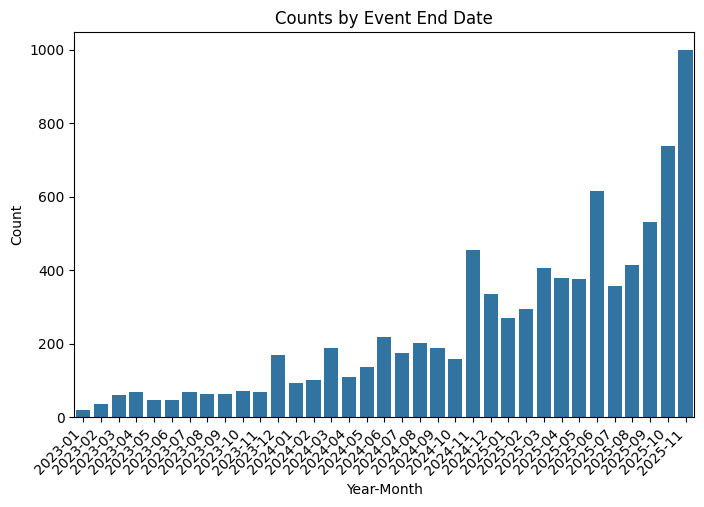

In [ ]:
#Total Events and Markets counts
display(len(markets_final))
display(len(markets_final.event_id.unique()))
display(markets_final.event_id.value_counts().reset_index().describe())

#Plot Year Month counts
markets_final['Year']  = pd.to_datetime(markets_final.endDate,format='mixed').dt.year
markets_final.Year.value_counts()
markets_final['YearMon'] = pd.to_datetime(markets_final['event_endDate']).dt.strftime("%Y-%m")
yearmoncounts = markets_final[['YearMon', 'event_id']].drop_duplicates().YearMon.value_counts().reset_index().sort_values('YearMon')

plt.figure(figsize=(8, 5))
sns.barplot(data=yearmoncounts, x='YearMon', y='count')

# Make x-axis labels fully visible
plt.xticks(rotation=45, ha='right')
plt.xlabel("Year-Month")
plt.ylabel("Count")
plt.title("Counts by Event End Date")



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Politics'),
  Text(1, 0, 'Other'),
  Text(2, 0, 'Business'),
  Text(3, 0, 'Other Current Affairs'),
  Text(4, 0, 'Crypto'),
  Text(5, 0, 'Sports'),
  Text(6, 0, 'Markets'),
  Text(7, 0, 'Pop Culture'),
  Text(8, 0, 'Economics'),
  Text(9, 0, 'Other Games')])

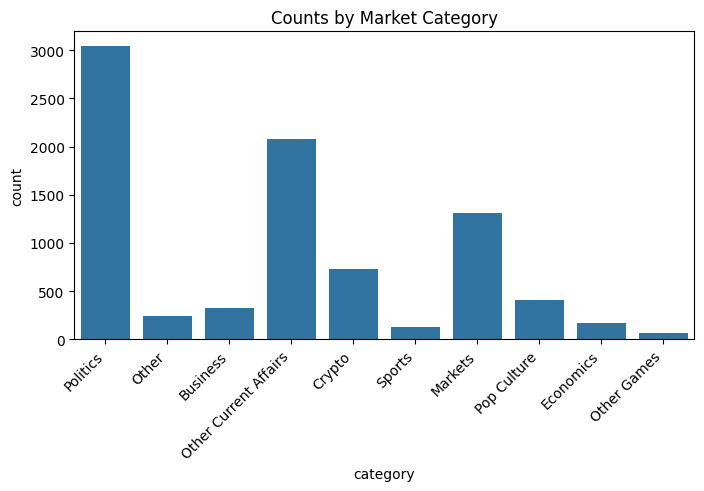

In [ ]:
#Plot counts by category
plt.figure(figsize=(8,4))
event_cat = markets_final[['event_id', 'category']].drop_duplicates()
sns.countplot(data=event_cat, x='category')
plt.title("Counts by Market Category")

plt.xticks(rotation=45, ha='right')

In [ ]:
#Volume and Price distributions
markets_final.volume.describe()
markets_final[['volume', 'Price_Start', 'Price_Mid', 'Price_End']].describe()
markets_final

,volume,Price_Start,Price_Mid,Price_End
count,2.463900e+04,24489.000000,24639.000000,24639.000000
mean,5.855414e+05,0.461949,0.284252,0.273731
std,1.303740e+07,0.130631,0.292309,0.437517
min,2.222000e-02,0.000500,0.000500,0.000500
25%,6.106314e+03,0.495000,0.031500,0.000500
50%,1.793157e+04,0.500000,0.175000,0.000500
75%,7.692201e+04,0.500000,0.490000,0.990500
max,1.531479e+09,1.000000,1.000000,1.459000


In [ ]:
##Find specific events
markets_final[markets_final.event_title.str.contains("AGI")].iloc[-1]
markets_final.lastTradePrice.value_counts(normalize = True)

lastTradePrice
0.0    0.731686
1.0    0.268314
Name: proportion, dtype: float64